In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from math import exp   
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.stats import linregress
import pandas as pd

In [2]:
from sympy import symbols, exp as sexp, diff, Derivative, Eq

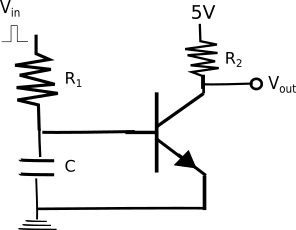

The object was to measure the voltage at the base of the transmitter (and later on at the base of R2) to determine the characteristics of the transistor.  Specifically to estimate the thermal coefficient $V_T$ and the scale current $I_{ES}$. The capacitor was to produce a comparatively slowly changing transistor base voltage with hopefully enough time for me to make measurements using an Arduino.  (This has since become slightly more complicated because the Arduino analog inputs have a time lag of 100 $\mu S$ which may add some measurement bias).

In [3]:
r1, r2, c, issym, vt, vin, vout, vbe, vc, t = symbols("R1 R2 C I_{ES} V_T V_{in} V_{out} V_{BE} V_C t")

In [4]:
 Eq((vin - vc)/r1 - c * Derivative(vc,t) - issym*(sexp(vc/vt)-1),0)

Eq(-C*Derivative(V_C, t) - I_{ES}*(exp(V_C/V_T) - 1) + (-V_C + V_{in})/R1, 0)

The above is a differential equation for the R1, C and base-emitter junction.  $V_C$ is the voltage across the capacitor.  Vin is a choice of 0 or 5 Volts as it is connected to one of the outputs of the Arduino digital pins.  By turning it on or off I was hoping to sweep through a range of voltages controlled by the time constand of R1 $\times$ C.  In my case R1 = 6K8 and C = $100 \mu F$.  I think R2 is about 5K.

It's basically a non linear differential equation which is impossible to solve using analytical methods.  Hence the attempt to solve it below using numerical methods.

Now I try to build my theoretical model using the equation above and some scientific libraries to integrate the equation to find what the solution would look like over time.
I am basically plotting the voltage across the capacitor as function of time.

In [5]:
r1val = 6800
r2val = 5000
cval = 100e-6

In [6]:
def model(t, y, vin):
    vcc=vin
    vt =  0.0321850033399526
    isval = 1.602564611659814e-12
    r=r1val
    c=cval
    
    vc = y
    try:
        vcp =  (vcc-vc)/(r*c) - isval * (exp(vc/vt)-1) /(c)
    except OverflowError:
        print (vc)
        return np.inf
    #print (vcp)
    return vcp
    
    

In [7]:
teval = np.linspace(0, .4,100)
res = solve_ivp(model, (0,.4), (0,),args=(5,), t_eval = teval, first_step=0.001)

[56.81583729]


/home/splat/.local/lib/python3.8/site-packages/scipy/integrate/_ivp/rk.py:109: RuntimeWarning: invalid value encountered in true_divide
  return norm(self._estimate_error(K, h) / scale)


In [8]:
x = res.t
y = res.y[0]

In [9]:
max60idx = np.argmax(res.y > .61)

Text(0.5, 1.0, 'Charging of $V_C$ over time(t)')

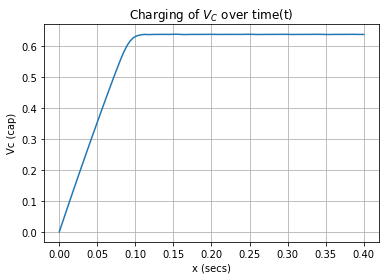

In [10]:
fig, ax = plt.subplots()

ax.plot(x,y)
ax.grid()
ax.set_xlabel("x (secs)")
ax.set_ylabel("Vc (cap)")
ax.set_title("Charging of $V_C$ over time(t)")

LinregressResult(slope=6.835735444183038, intercept=0.007932451484825798, rvalue=0.9996269961182911, pvalue=2.5047519270349017e-34, stderr=0.04075386421266013, intercept_stderr=0.002115122684003866)


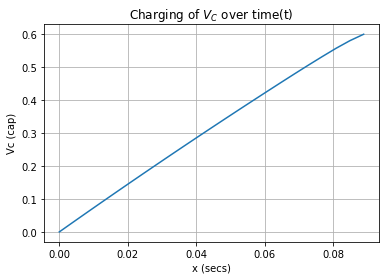

In [11]:
fig, ax = plt.subplots()

ax.plot(x[:max60idx],y[:max60idx])
ax.grid()
ax.set_xlabel("x (secs)")
ax.set_ylabel("Vc (cap)")
ax.set_title("Charging of $V_C$ over time(t)")
res = linregress(x[:max60idx],y[:max60idx])
vcslope = res.slope
print (res)

In [12]:
capcurrent = vcslope*cval
capcurrent

0.0006835735444183038

In [13]:
teval = np.linspace(0, 1,100)
res = solve_ivp(model, (0,1), (.7,),args=(0,), t_eval = teval, first_step=0.001)

In [14]:
x = res.t
y = res.y[0]

Text(0.5, 1.0, 'Discharging of C over time(t)')

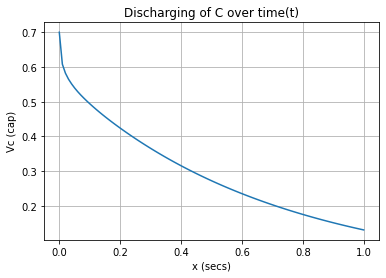

In [15]:
fig, ax = plt.subplots()

ax.plot(x,y)
ax.grid()
ax.set_xlabel("x (secs)")
ax.set_ylabel("Vc (cap)")
ax.set_title("Discharging of C over time(t)")

The results are unsurprising as the capacitor charges up to ( or discharges from ) 0.7 volts approximately.  Anything higher and the transistor conducts so the results are at least realistic.

Now I look at the results obtained from direct measurement via the Arduino analog input pin.

In [16]:
measurements = np.array([
    [ 0, 0.00, 4.98], 
    [ 4, 0.03, 4.97], 
    [ 8, 0.07, 4.98], 
    [ 12, 0.09, 4.98], 
    [ 16, 0.13, 4.97], 
    [ 20, 0.15, 4.98], 
    [ 24, 0.18, 4.97], 
    [ 28, 0.21, 4.97], 
    [ 32, 0.23, 4.98], 
    [ 36, 0.26, 4.98], 
    [ 40, 0.28, 4.97], 
    [ 44, 0.31, 4.98], 
    [ 48, 0.34, 4.98], 
    [ 52, 0.37, 4.98], 
    [ 56, 0.40, 4.97], 
    [ 60, 0.42, 4.98], 
    [ 64, 0.45, 4.97], 
    [ 68, 0.47, 4.97], 
    [ 72, 0.50, 4.96], 
    [ 76, 0.52, 4.95], 
    [ 80, 0.55, 4.90], 
    [ 84, 0.57, 4.81], 
    [ 88, 0.60, 4.54], 
    [ 92, 0.62, 3.82], 
    [ 96, 0.64, 2.05], 
    [ 100, 0.67, 0.06], 
    [ 104, 0.70, 0.04], 
    [ 108, 0.71, 0.03], 
    [ 112, 0.72, 0.02], 
    [ 116, 0.73, 0.02], 
    [ 120, 0.73, 0.02], 
    [ 125, 0.74, 0.02], 
    [ 129, 0.74, 0.02], 
    [ 133, 0.74, 0.02], 
    [ 137, 0.74, 0.02], 

 ])

In [17]:
dfmeasure =  pd.DataFrame(measurements)
dfmeasure.columns = ['time', 'v1', 'v2']
# ADC is the measure obtained from Arduino analogRead which returns a value from 0 to 1023.
# I divide that by  and multiply by 5 to get a voltage.

In [18]:
plt

<module 'matplotlib.pyplot' from '/home/splat/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

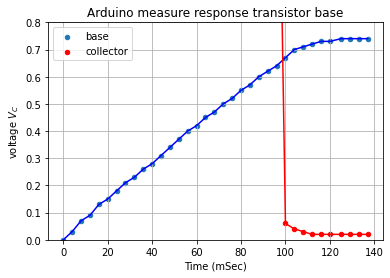

In [19]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure response transistor base')

x=dfmeasure['time']

f1=interp1d(dfmeasure['time'], dfmeasure['v1'])
f2=interp1d(dfmeasure['time'], dfmeasure['v2'])

ax1 = dfmeasure.plot('time', 'v1', kind='scatter', ax=ax, label='base')
ax1 = dfmeasure.plot('time', 'v2', kind='scatter', ax=ax, color='r', label='collector')
ax1.plot(x, f1(x),'b')
ax1.plot(x, f2(x), 'r')
ax1.set_xlabel('Time (mSec)')
ax1.set_ylabel('voltage $V_C$')
ax1.set_ylim(0,.8)
ax1.legend()
ax1.grid()

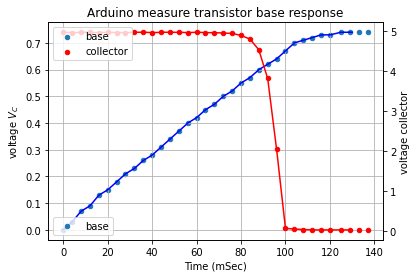

In [31]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure transistor base response')

ax1 = dfmeasure.plot('time', 'v1', kind='scatter', ax=ax, label='base')
ax1.plot(x, f1(x),'b')
ax1.legend(loc='lower left')
# ask matplotlib for the plotted objects and their labels
lines1, labels1 = ax1.get_legend_handles_labels()
ax2 = ax1.twinx()
ax2 = dfmeasure.plot('time', 'v2', kind='scatter', ax=ax2, color='r', label='collector')

ax2.plot(x, f2(x), 'r')   
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.set_xlabel('Time (mSec)')
ax1.set_ylabel('voltage $V_C$')
ax2.set_ylabel('voltage collector')

ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.grid()

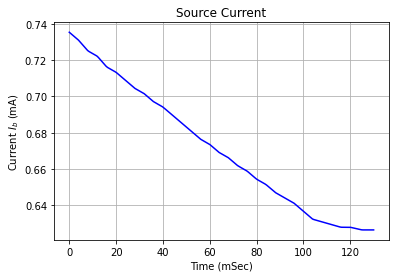

In [32]:
fig, ax = plt.subplots()

ax.set_title('Source Current')
x = np.linspace(0,130,200)
ax.plot(x, 1000*(5 - f1(x))/r1val,'b')
 
ax.set_xlabel('Time (mSec)')
ax.set_ylabel('Current $I_b$ (mA)')

ax.grid()

In [33]:
df = dfmeasure[dfmeasure['time']<100]
res = linregress(df['time']/1000, df['v1'])
capcurrent = res.slope*cval
print (res.slope, capcurrent)
print ("{:.2f} mA going into capacitor per second".format(capcurrent*1000))
print ("or {:3.1f} \N{greek small letter mu}A per mSec".format(capcurrent*1e6))

6.6576923076923045 0.0006657692307692305
0.67 mA going into capacitor per second
or 665.8 μA per mSec


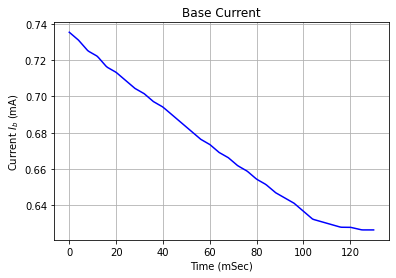

In [34]:
fig, ax = plt.subplots()

ax.set_title('Base Current')
x = np.linspace(0,130,200)
ax.plot(x, 1000*(5 - f1(x))/r1val-capcurrent/1000,'b')
 
ax.set_xlabel('Time (mSec)')
ax.set_ylabel('Current $I_b$ (mA)')

ax.grid()

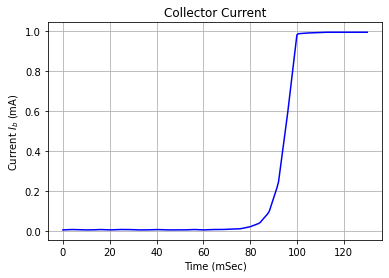

In [35]:
fig, ax = plt.subplots()

ax.set_title('Collector Current')
x = np.linspace(0,130,200)
ax.plot(x, 1000*(5 - f2(x))/r2val,'b')
 
ax.set_xlabel('Time (mSec)')
ax.set_ylabel('Current $I_b$ (mA)')

ax.grid()

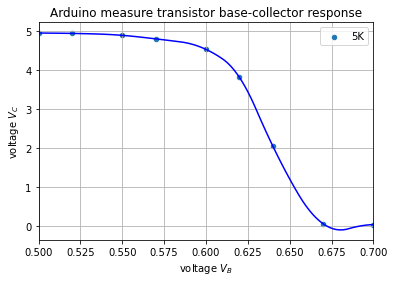

In [36]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure transistor base-collector response')

df=dfmeasure.drop_duplicates('v1') 
xi = np.linspace(.5,.7,100)
f3=interp1d( df['v1'], df['v2'], kind='quadratic')

ax1 = dfmeasure.plot('v1', 'v2', kind='scatter', ax=ax, label='5K')
ax1.plot(xi, f3(xi),'b')

ax1.set_xlim(.5,.7)
ax1.set_xlabel('voltage $V_B$')
ax1.set_ylabel('voltage $V_C$')
ax1.grid()

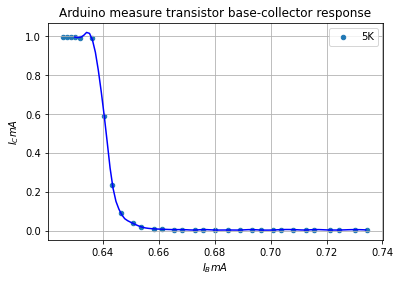

In [37]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure transistor base-collector response')


df=dfmeasure.drop_duplicates('v1').copy() 
df.loc[:,'bcurrent'] = ((5 - df['v1'])/r1val-capcurrent/1000)*1000 # (convert to milliamps)
df.loc[:,'ccurrent'] = 1000*(5 - df['v2'])/r2val # 1000 * (convert to milliAmps)
xi = np.linspace(.63, .734,100)
f3=interp1d( df['bcurrent'], df['ccurrent'], kind='quadratic')
#f2=interp1d(dfmeasure['time'], dfmeasure['v2'])

ax1 = df.plot('bcurrent', 'ccurrent', kind='scatter', ax=ax, label='5K')
#ax1 = dfmeasure.plot('time', 'v2', kind='scatter', ax=ax, color='r', label='collector')
ax1.plot(xi, f3(xi),'b')
#ax1.plot(x, f2(x), 'r')
#ax1.set_xlim(.5,.7)
ax1.set_xlabel('$I_B mA$')
ax1.set_ylabel('$I_C mA$')
ax1.grid()

In [38]:
df


time    v1    v2  bcurrent  ccurrent
0     0.0  0.00  4.98  0.734628     0.004
1     4.0  0.03  4.97  0.730217     0.006
2     8.0  0.07  4.98  0.724334     0.004
3    12.0  0.09  4.98  0.721393     0.004
4    16.0  0.13  4.97  0.715511     0.006
5    20.0  0.15  4.98  0.712570     0.004
6    24.0  0.18  4.97  0.708158     0.006
7    28.0  0.21  4.97  0.703746     0.006
8    32.0  0.23  4.98  0.700805     0.004
9    36.0  0.26  4.98  0.696393     0.004
10   40.0  0.28  4.97  0.693452     0.006
11   44.0  0.31  4.98  0.689040     0.004
12   48.0  0.34  4.98  0.684628     0.004
13   52.0  0.37  4.98  0.680217     0.004
14   56.0  0.40  4.97  0.675805     0.006
15   60.0  0.42  4.98  0.672864     0.004
16   64.0  0.45  4.97  0.668452     0.006
17   68.0  0.47  4.97  0.665511     0.006
18   72.0  0.50  4.96  0.661099     0.008
19   76.0  0.52  4.95  0.658158     0.010
20   80.0  0.55  4.90  0.653746     0.020
21   84.0  0.57  4.81  0.650805     0.038
22   88.0  0.60  4.54  0.646393     0.092
23   92.0  0.62  3.82  0.643452     0.236
24   96.0  0.64  2.05  0.640511     0.590
25  100.0  0.67  0.06  0.636099     0.988
26  104.0  0.70  0.04  0.631687     0.992
27  108.0  0.71  0.03  0.630217     0.994
28  112.0  0.72  0.02  0.628746     0.996
29  116.0  0.73  0.02  0.627275     0.996
31  125.0  0.74  0.02  0.625805     0.996

In [39]:
df1 = df[13:25]
linregress(df1['bcurrent'], df1['ccurrent'])


LinregressResult(slope=-8.760011429659974, intercept=5.864425402266887, rvalue=-0.6656341317602029, pvalue=0.01814338092082274, stderr=3.1057741062899575, intercept_stderr=2.049408351480763)

This doesn't look like a particularly good regression so I look at the graph.

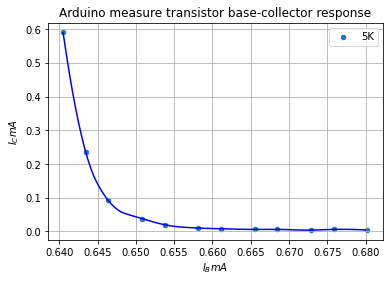

In [40]:
fig, ax = plt.subplots()

ax.set_title('Arduino measure transistor base-collector response')


xi = np.linspace(.64052 ,.68, 100)
f3=interp1d( df1['bcurrent'], df1['ccurrent'], kind='quadratic')

ax1 = df1.plot('bcurrent', 'ccurrent', kind='scatter', ax=ax, label='5K')
ax1.plot(xi, f3(xi),'b')

ax1.set_xlabel('$I_B mA$')
ax1.set_ylabel('$I_C mA$')
ax1.grid()